# Convergent approaches to AI Explainability for HEP muonic particles pattern recognition

# 4) xAI Convergence

## Environment setup

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import math
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # if plotting the kernel crashes

import tensorflow as tf
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from models.cnn import build_cnn, build_cnn_tracin
from models.convsdt import *
from utils.metrics import spread, efficiency
from utils.plot import plot_history, plot_cm, plot_explanation, plot_logs, plot_image
from utils.dataset import XaiDataset
from attribution.attribution import ram_per_feature, interpolate_image, add_noise, smoothgrad, get_heatmaps
from tracin.tracin import get_trackin_grad, find_prop_opp

random.seed(0)

print('Libraries imported')

### Downloading data

In [2]:
# get data from my Drive, it downloads (and unzip) less stuff (i.e. only the used one) and data are already splitted
# ! rm -rf sample_data
# ! pip install --upgrade --no-cache-dir gdown -q
# ! gdown --id 1s6JZuJPAqUtnnvezDepApE4BMKo3FP4q
# print('\nUnzipping data...')
# ! unzip -q muontriggerdata-master.zip
# ! rm -rf muontriggerdata-master.zip

print('\nLoading images with noise...')
train_images = np.load('../muontriggerdata-master/train_images_with_noise.npy')
test_images = np.load('../muontriggerdata-master/test_images_with_noise.npy')

print('\nLoading images without noise...')
train_images_without_noise = np.load('../muontriggerdata-master/train_images_without_noise.npy')
test_images_without_noise = np.load('../muontriggerdata-master/test_images_without_noise.npy')

print('\nLoading labels...')
train_labels = np.load('../muontriggerdata-master/train_labels.npy')
test_labels = np.load('../muontriggerdata-master/test_labels.npy')

print('\nLoading completed.')

## Data Preprocessing

### Attribution

In [3]:
train_labels_df = pd.DataFrame(train_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])
test_labels_df = pd.DataFrame(test_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])

Our work is focused **ONLY** on predicting values for *pt* and *eta*; therefore, we will drop the remaining parameters in the labels.

In [4]:
train_labels_df = train_labels_df.drop(columns=['phi', '0', 'nhits'])
test_labels_df = test_labels_df.drop(columns=['phi', '0', 'nhits'])

### DecTree

In [5]:
train_labels_tree = np.array([train_label[:2] for train_label in train_labels])
test_labels_tree = np.array([test_label[:2] for test_label in test_labels])

kd = True # are we testing a model trained via Knowledge Distillation?
MEAN = 11.863591194152832 if kd else train_labels_df.mean()['pt']
STD = 4.761418342590332 if kd else train_labels_df.std()['pt']

train_labels_tree[:,0] = (train_labels[:,0] - MEAN) / STD
test_labels_tree[:,0] = (test_labels[:,0] - MEAN) / STD

# our numpy data and dataframes ---> torch tensors
train_images_tree = train_images.reshape(-1, 1, 9, 384)
test_images_tree = test_images.reshape(-1, 1, 9, 384)
train_labels_tree = train_labels_tree.reshape(-1, 2)
test_labels_tree = test_labels_tree.reshape(-1, 2)

train_images_tree = torch.tensor(train_images_tree, dtype=torch.float32)
test_images_tree = torch.tensor(test_images_tree, dtype=torch.float32)

train_labels_tree = torch.tensor(train_labels_tree, dtype=torch.float32)
test_labels_tree = torch.tensor(test_labels_tree, dtype=torch.float32)

train_data_list = []

for x, y in zip(train_images_tree, train_labels_tree):
    train_data_list.append((x, y))

test_data_list = []

for x, y in zip(test_images_tree, test_labels_tree):
    test_data_list.append((x, y))

train_dataset = XaiDataset(train_data_list)
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataset = XaiDataset(test_data_list)
test_dataloader = DataLoader(test_dataset, batch_size=64)

### TracIn

In [6]:
# remove "bad" images
train_bad_idxs = np.where(train_labels[:, 4] <= 17)
train_images_tracin = train_images[train_bad_idxs]
train_images_without_noise_tracin = train_images_without_noise[train_bad_idxs]
train_labels_tracin = train_labels[train_bad_idxs]

test_bad_idxs = np.where(test_labels[:, 4] <= 17)
test_images_tracin = test_images[test_bad_idxs]
test_images_without_noise_tracin = test_images_without_noise[test_bad_idxs]
test_labels_tracin = test_labels[test_bad_idxs]

## Evaluation

We base the next xAI approaches on the ```True/False Positives/Negatives``` division of Attribution CNN.

In [10]:
model = build_cnn()
model.load_weights('ckpts/cnn_model/cnn_model').expect_partial()
ram_model = Model(inputs=model.input, outputs=(model.layers[-5].output, model.layers[-1].output))

model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer=tf.keras.optimizers.legacy.Adam())
model.evaluate(x=test_images, y=test_labels_df)

2952/2952 [==============================] - 25s 7ms/step - loss: 0.6027 - spread: 1.1176 - efficiency: 0.8838


[0.6051385998725891, 1.1227219104766846, 0.8807213306427002]

2952/2952 [==============================] - 360s 122ms/step


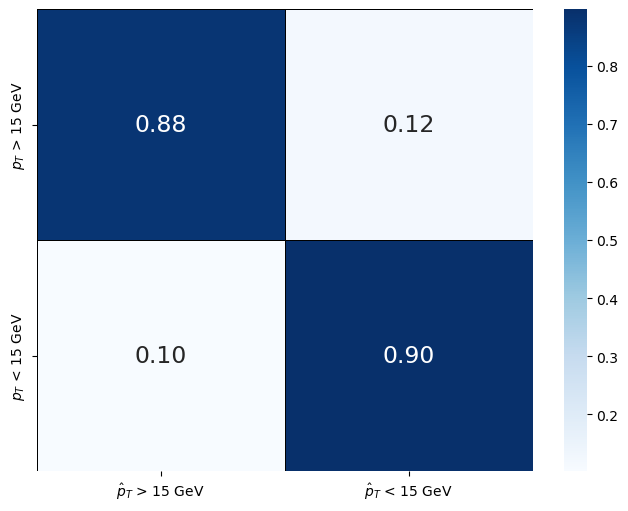

In [12]:
# inspect first 10 results
y_hat = model.predict(test_images)

pred_df = pd.DataFrame(y_hat, columns=['pt_pred', 'eta_pred'])
frames = [test_labels_df, pred_df]
compare_df = pd.concat(frames, axis=1)

tp_index, fn_index, fp_index, tn_index, cm_plot = plot_cm(compare_df)

## Explainability

In [ ]:
index = random.choice(tp_index)
while abs(compare_df.iat[index, 0] - compare_df.iat[index, 2]) < 6:
    index = random.choice(tp_index)

assert test_labels[index][4] <= 17 # make sure this test image is addressed by tracin

### CNN Explainability

In [7]:
index = 19308

##################################################  Inspection  ##################################################
1/1 [==============================] - 0s 20ms/step


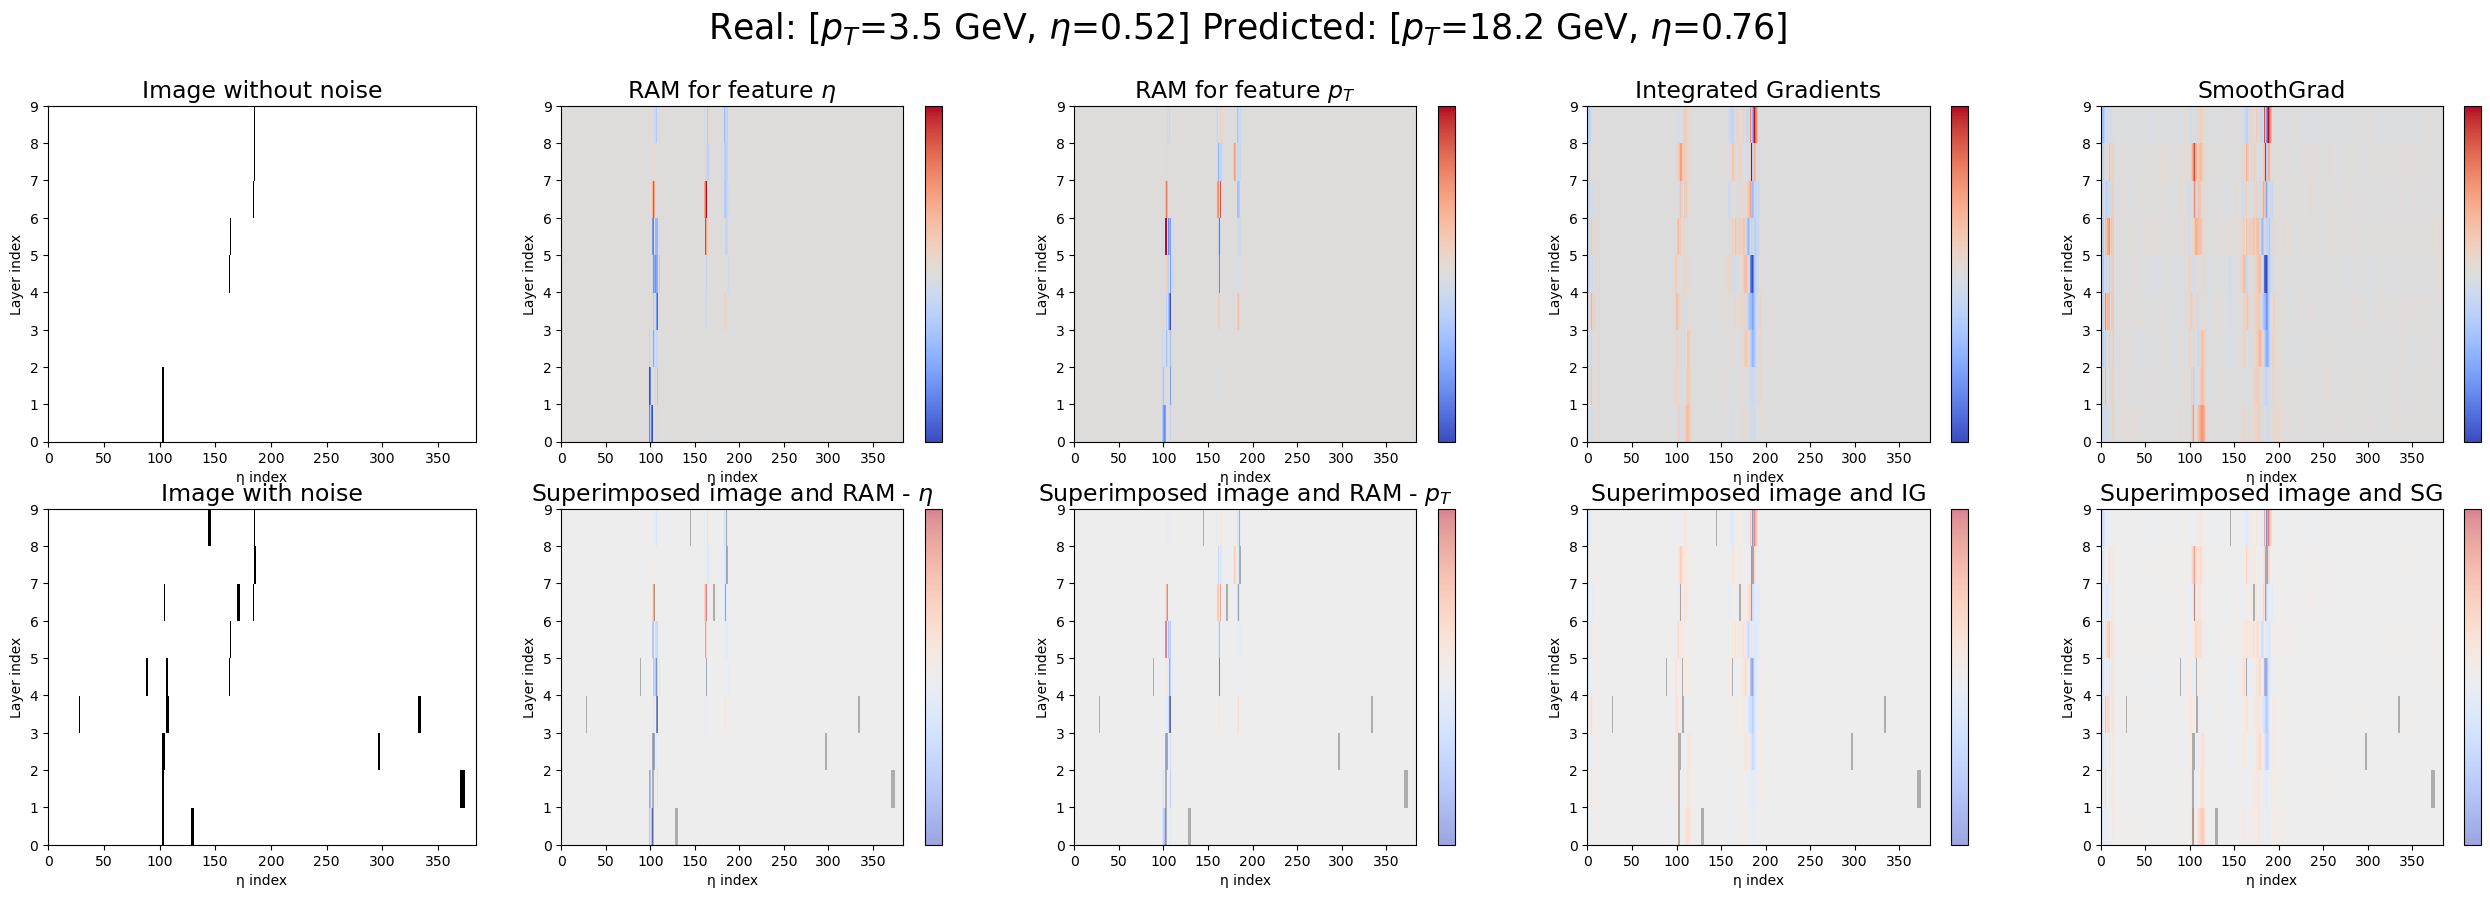

Index: 19308

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [16]:
print('#'*50, ' Inspection ', '#'*50)
ram_pt, ram_eta, ig, sg = get_heatmaps(model, ram_model, test_images[index])
plot_explanation(test_images[index], test_images_without_noise[index], ram_eta, ram_pt, ig, sg, test_labels[index], y_hat[index], index, save=True)
print(f'Index: {index}')
print('\n', '-'*160, '\n')

### ConvSDT Explainability

In [8]:
model_tree = ConvSDT(latent_dim=768, output_dim=2, depth=5)
model_tree.load_state_dict(torch.load('ckpts/convSDT_model_distilled.pth'))
model_tree.eval()

STD_KD = 4.761418342590332
MEAN_KD = 11.863591194152832

Explanation for test image 19308


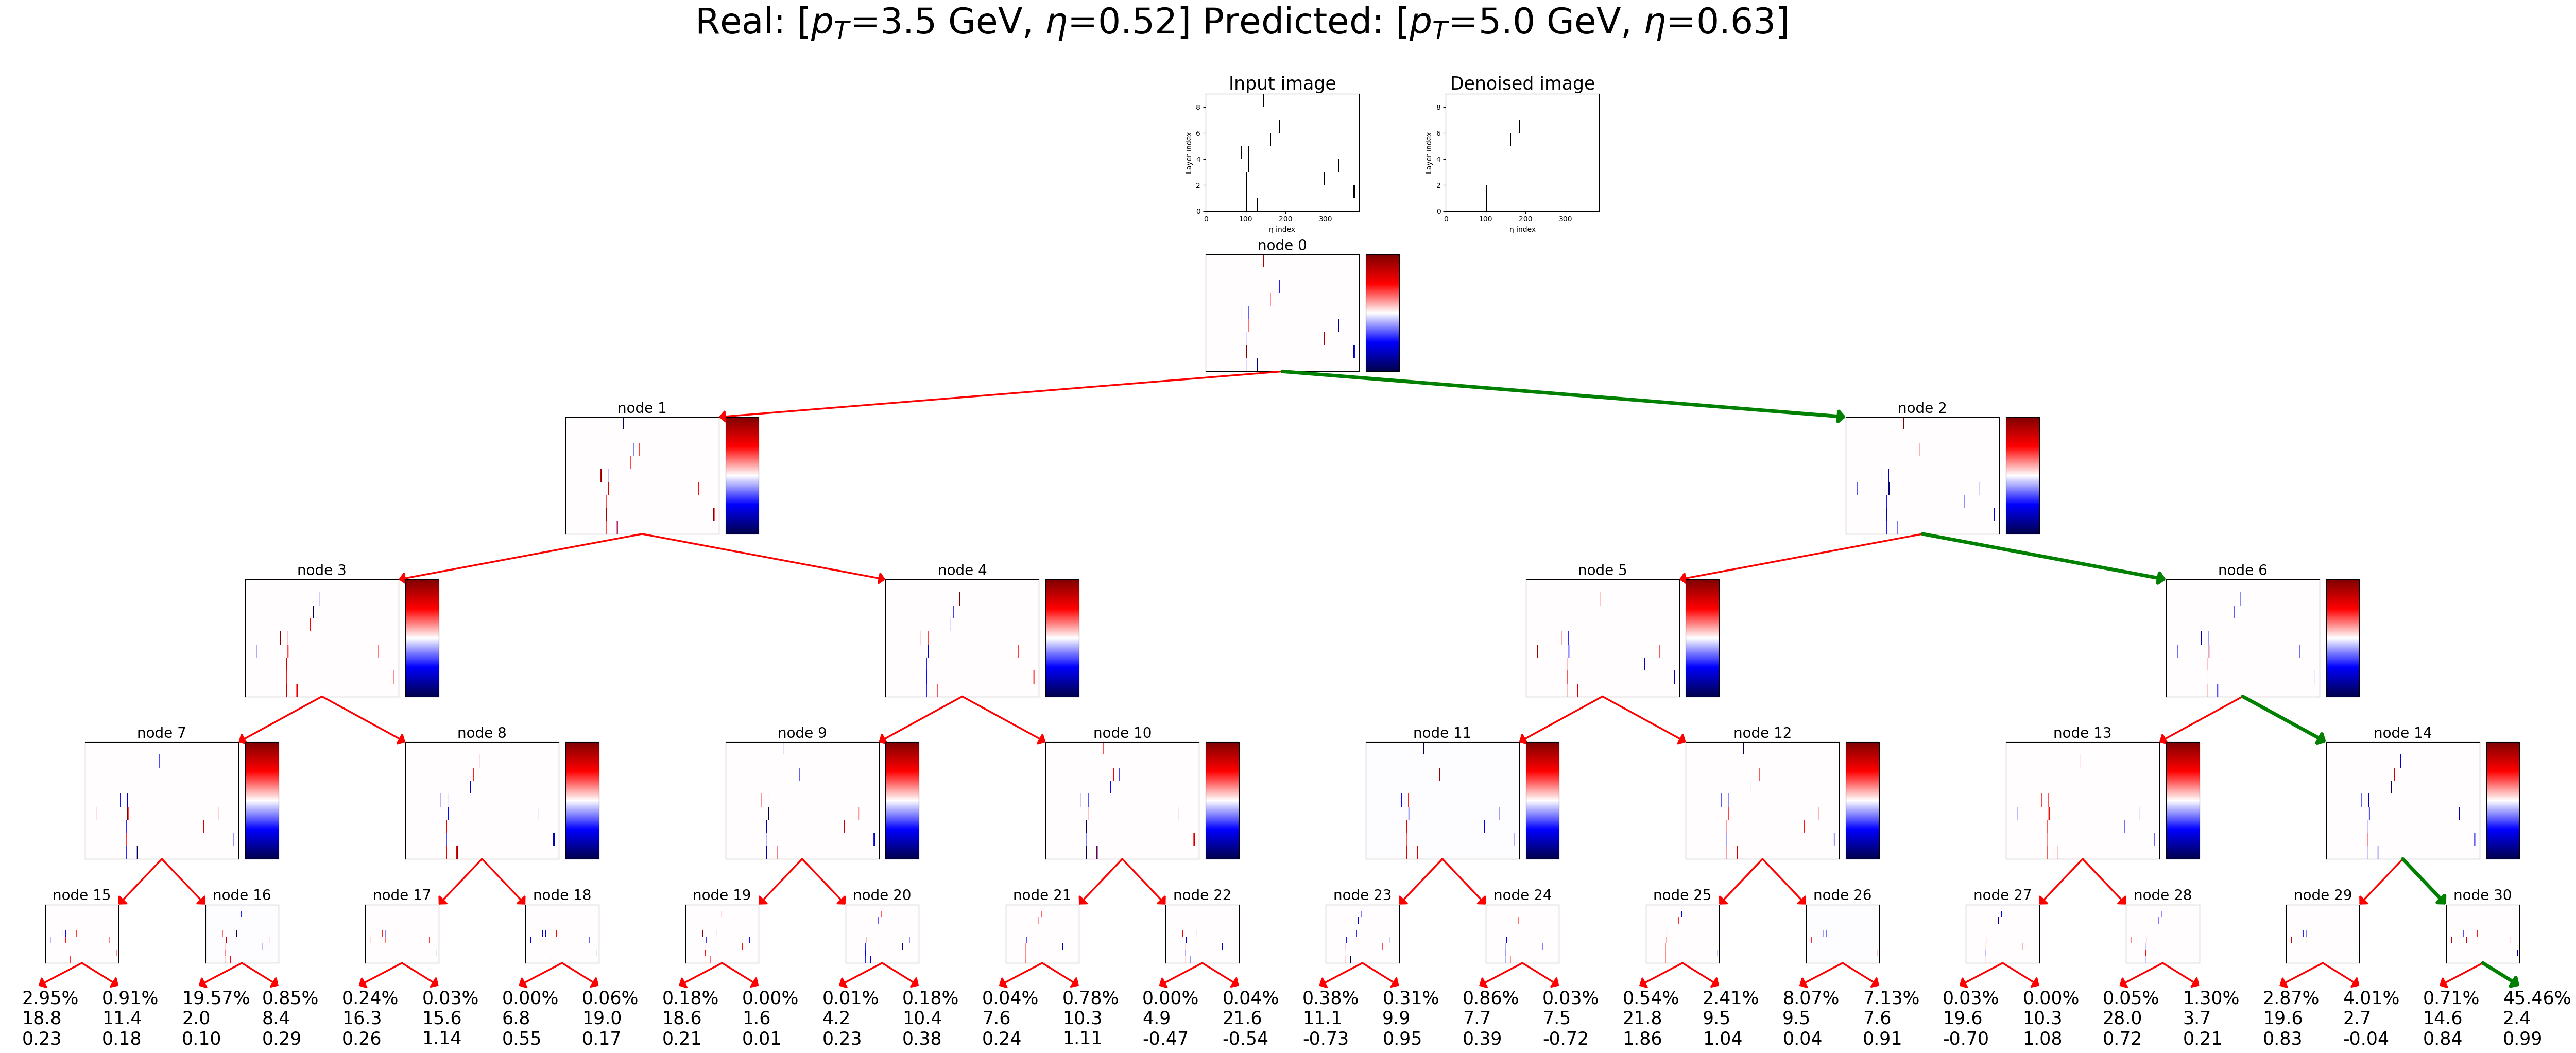


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [10]:
print('Explanation for test image ' + str(index))
explain_image(model_tree, test_images_tree[index], test_labels_tree[index][0], test_labels_tree[index][1], test_images_without_noise[index], mean=MEAN_KD, std=STD_KD, title='dectree_'+str(index)+'.jpg')
print('\n', '-'*160, '\n')

### TracIn Explainability

Test image [16735]:


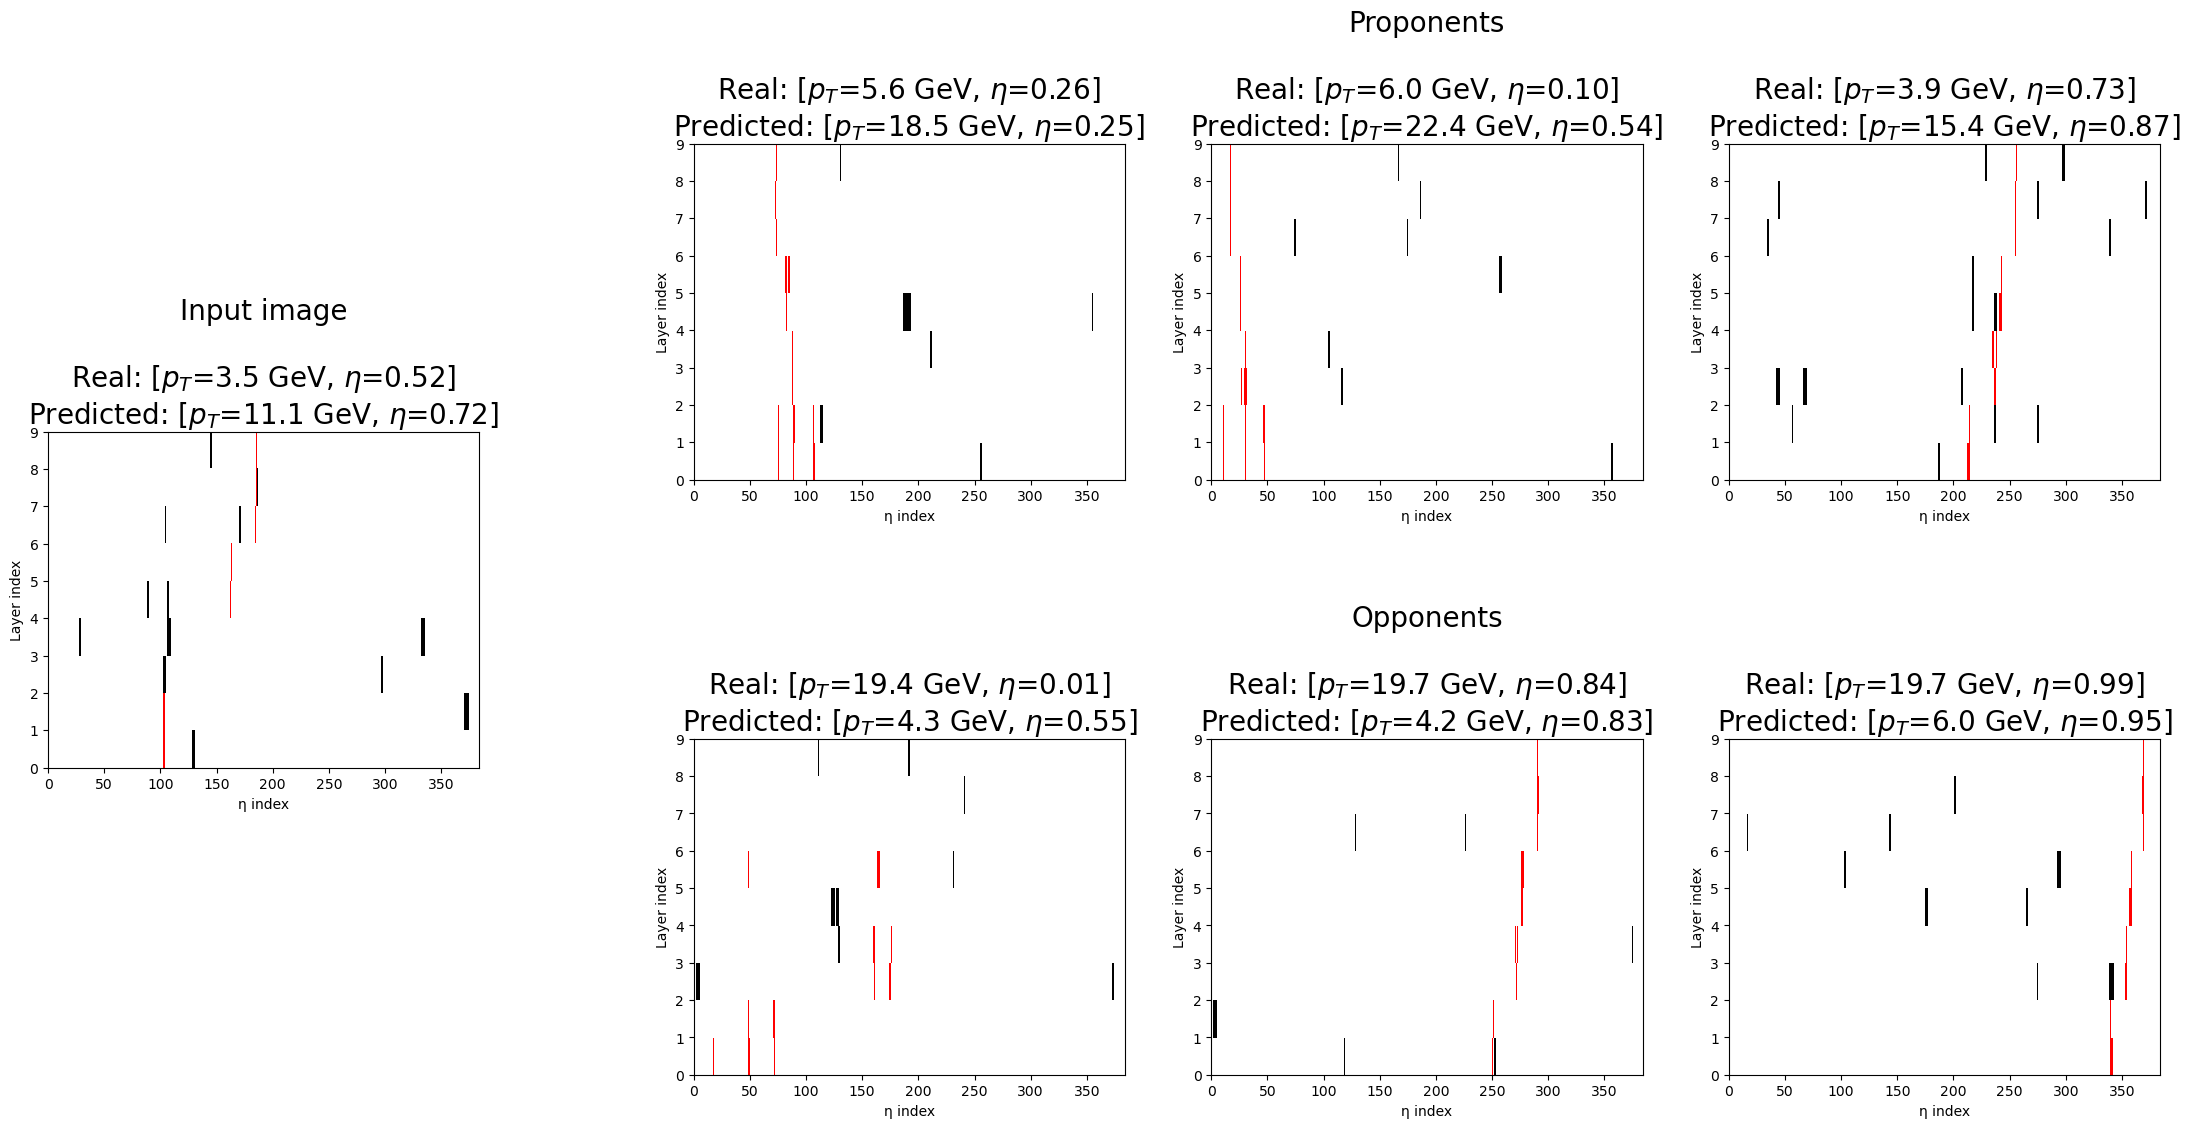

Proponents indices:  [486532, 156275, 620559]
Opponents indices:  [64903, 520621, 200021]


In [15]:
for i in range(len(test_labels_tracin)):
    if test_labels[index][0] == test_labels_tracin[i][0] and test_labels[index][1] == test_labels_tracin[i][1]:
        idx = i
        break

with open('tracin/trackin_train.pkl', 'rb') as f:
    trackin_train = pickle.load(f)
with open('tracin/trackin_test.pkl', 'rb') as f:
    trackin_test = pickle.load(f)

find_prop_opp(trackin_train, trackin_test, idx, train_images_tracin, train_images_without_noise_tracin, test_images_tracin, test_images_without_noise_tracin, topk=3, title='tracin_'+str(index)+'.jpg')